In [1]:
import sys
import os.path as op
from glob import glob
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2
import scipy.stats as stats
from scipy.interpolate import interp1d
import seaborn as sns
import statsmodels.api as sm
from rpy2.robjects.packages import importr

# from statsmodels.gam.smooth_basis import BSplines
# from statsmodels.gam.gam import GLMGam
# import patsy

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

sys.path.append(op.join(op.expanduser("~"), "code", "style"))
from colors import get_colors

co, palettes = get_colors()

from general.array import array_operations as aop
from general.basic.config import get_plot_defaults, set_rcparams

mpl.rcParams = set_rcparams(mpl.rcParams)
mpl.rcParams["axes.grid"] = False
d = get_plot_defaults()
co = d.get("colors", None)
colws = d.get("colws", None)
font = d.get("font", None)
lws = d.get("lws", None)
pad = d.get("pad", None)
palettes = d.get("palettes", None)
from general.basic.helper_funcs import *
from general.basic.str_methods import *

In [7]:
# rutils = importr("utils")
# rutils.install_packages("mgcv")
mgcv = importr("mgcv")

# Setup

In [2]:
# Get paths to relevant directories.
proc_date = "2023-12-20"
proj_dir = op.join(op.expanduser("~"), "box/projects/leads_tau_spread")
ssheet_dir = op.join(proj_dir, "data", "ssheets")
loni_dir = op.join(ssheet_dir, "loni", f"download_{proc_date}")
fig_dir = op.join(proj_dir, "figs", "hai_2024")

In [3]:
# Import ROI extraction and CDR data.
tau_all_agg = pd.read_csv(op.join(ssheet_dir, "tau-rois-agg_2024-02-17.csv"))
tau_eoad = pd.read_csv(op.join(ssheet_dir, "tau-rois-agg_eoad-long_2024-02-06.csv"))
cdr_eoad = pd.read_csv(
    op.join(ssheet_dir, "cdr-sb_eoad-long_formatted_193subjs_2023-12-30.csv")
)

In [4]:
# Find all subjects with 2+ FTP scan and 1+ CDR scores.
keep_parcs = ["metarois", "earlyrois", "fsroi_bilat"]
select_subjs = np.intersect1d(
    tau_all_agg.query("(dx=='EOAD') & (ftp_visits>1)")["subj"], cdr_eoad["subj"]
)

# Format everything in one dataframe before modeling.
cols = ["subj", "date", "key", "val"]
data = []

# FTP SUVRs.
_data = (
    tau_all_agg.query(
        "(parc=={}) & (subj=={})".format(keep_parcs, select_subjs.tolist())
    )
    .loc[:, ["subj", "ftp_date", "roi", "suvr"]]
    .copy()
)
_data.columns = cols
data.append(_data)

# CDR-SB.
_data = cdr_eoad.loc[
    np.isin(cdr_eoad["subj"], select_subjs), ["subj", "cdr_date", "cdr_sb"]
].copy()
_data.insert(2, "key", "cdr_sb")
_data.columns = cols
data.append(_data)

# Combine data.
data = (
    pd.concat(data, axis=0).sort_values(["key", "subj", "date"]).reset_index(drop=True)
)

print(f"data: {data.shape}")
print(f"{data['subj'].nunique()} subjects, {data['key'].nunique()} keys")

data: (21602, 4)
187 subjects, 46 keys


In [5]:
def date_diff(date1, date2, abs=False):
    """Return date2 - date1 in years."""
    if isinstance(date1, str):
        date1 = datetime.date(*[int(x) for x in date1.split("-")])
    if isinstance(date2, str):
        date2 = datetime.date(*[int(x) for x in date2.split("-")])
    try:
        diff = (date2 - date1).days / 365.24
        if abs:
            return np.abs(diff)
        else:
            return diff
    except TypeError:
        return None


def compute_change_ols(df):
    if df.shape[0] == 1:
        return [1, np.nan, np.nan]
    df["yrs_from_bl"] = [date_diff(df["date"].min(), x) for x in df["date"]]
    slope, icpt, *_ = stats.linregress(df["yrs_from_bl"], df["val"])
    return [df.shape[0], icpt, slope]

In [128]:
slope, icpt, *_ = stats.linregress(df["yrs_from_bl"], df["val"])
print(f"slope: {slope:.3f}, icpt: {icpt:.3f}")

slope: -0.104, icpt: 2.804


In [124]:
%timeit stats.linregress(df["yrs_from_bl"], df["val"])
%timeit fit = sm.OLS(df["val"], sm.add_constant(df["yrs_from_bl"])).fit()

34.9 µs ± 242 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
356 µs ± 2.85 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [123]:
stats.linregress(df["yrs_from_bl"], df["val"])
fit = sm.OLS(df["val"], sm.add_constant(df["yrs_from_bl"])).fit()

print(fit.predict())
print(fit.resid.values)
print(fit.summary())

[2.80350651 2.69313688 2.57535224 2.4695457 ]
[ 0.05942202 -0.14877623  0.12683929 -0.03748508]
                            OLS Regression Results                            
Dep. Variable:                    val   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     2.906
Date:                Sat, 17 Feb 2024   Prob (F-statistic):              0.230
Time:                        17:28:12   Log-Likelihood:                 3.3826
No. Observations:                   4   AIC:                            -2.765
Df Residuals:                       2   BIC:                            -3.993
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/Users/dschonhaut/mambaforge/envs/nipy310/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [172]:
data_ols = data.groupby(["key", "subj"]).apply(compute_change_ols)
data_ols = (
    pd.DataFrame(
        data_ols.tolist(), index=data_ols.index, columns=["n_obs", "icpt", "slope"]
    )
    .reset_index()
    .dropna()
    .reset_index(drop=True)
)

In [173]:
data_ols.groupby("key").agg({"icpt": mean_sd, "slope": mean_sd}).iloc[:100, :]

,icpt,slope
key,,
amygdala,1.74 ± 0.33,0.04 ± 0.09
bankssts,2.57 ± 0.72,0.09 ± 0.19
bltemp,2.18 ± 0.51,0.10 ± 0.14
caudalanteriorcingulate,1.32 ± 0.27,0.06 ± 0.08
caudalmiddlefrontal,2.08 ± 0.67,0.11 ± 0.15
cdr_sb,3.51 ± 1.74,1.91 ± 1.82
cmfg,2.08 ± 0.67,0.11 ± 0.15
cuneus,1.78 ± 0.59,0.09 ± 0.11
entorhinal,1.71 ± 0.28,0.06 ± 0.09


In [58]:
df["date_last"] = df["date"].shift(1)
df["val_last"] = df["val"].shift(1)

0          None
1    2019-08-21
2    2020-09-11
3    2021-10-29
Name: date, dtype: object

In [109]:
idx

('L_amygdala', 'LDS0070166')

In [114]:
for idx, df in data.groupby(["key", "subj"]):
    if idx == ("temporal", "LDS0070166"):
        df["yrs_from_bl"] = [date_diff(df["date"].min(), x) for x in df["date"]]
        print(f"idx: {idx}")
        break

idx: ('temporal', 'LDS0070166')


In [37]:
data = (
    cdr_eoad.query("(cdr_visits>1)")
    .sort_values(["subj", "cdr_date"])
    .groupby(["subj"])["cdr_sb"]
    .shift(1)
)

# tau_eoad["vol_last"] = (
#     tau_eoad.sort_values(["subj", "roi", "visit"])
#     .groupby(["subj", "roi"])["vol"]
#     .shift(1)
# )

0       NaN
1       8.0
2      15.0
3       NaN
4       6.0
       ... 
510     4.0
511     NaN
512     4.0
513     NaN
514     0.0
Name: cdr_sb, Length: 508, dtype: float64

In [29]:
tau_eoad.head()

,subj,parc,roi,visit,dx,ftp_date,ftp_visits,ftp_yrs_from_bl,ftp_yrs_from_last,site,age_at_ftp,sex,educ,pca,ppa,severity_bl,converted,cog_sym_age,cog_pri_sym,yrs_onset_to_ftp,apoe4_alleles,fbb_cl_bl,mmse_bl,cdr,cdr_sb_bl,cdr_sb_annchg,roi_full,roi_order,suvr,vol,age_at_ftp_bl,suvr_bl,vol_bl,suvr_chg_from_bl,vol_chg_from_bl,suvr_chg_from_last,suvr_annchg_from_last,vol_chg_from_last,vol_annchg_from_last
0,LDS0070166,earlyrois,bltemp,1,EOAD,2019-08-21,4,0.000000,NaN,7,56.443532,f,12.0,0.0,0.0,Dementia,NaN,49.0,exec_attn,7.443532,0.0,98.440827,9.0,1.0,8.0,2.090896,Basolateral Temporal,2,3.052760,40007,56.443532,3.052760,40007,0.000000,0,NaN,NaN,NaN,NaN
1,LDS0070166,earlyrois,bltemp,2,EOAD,2020-09-11,4,1.059548,1.059548,7,57.503080,f,12.0,0.0,0.0,Dementia,NaN,49.0,exec_attn,8.503080,0.0,98.440827,9.0,1.0,8.0,2.090896,Basolateral Temporal,2,2.687151,37174,56.443532,3.052760,40007,-0.365609,-2833,-0.365609,-0.345061,-2833.0,-2673.781008
2,LDS0070166,earlyrois,bltemp,3,EOAD,2021-10-29,4,2.190281,1.130732,7,58.633812,f,12.0,0.0,0.0,Dementia,NaN,49.0,exec_attn,9.633812,0.0,98.440827,9.0,1.0,8.0,2.090896,Basolateral Temporal,2,2.857845,34701,56.443532,3.052760,40007,-0.194915,-5306,0.170694,0.150959,-2473.0,-2187.078087
3,LDS0070166,earlyrois,bltemp,4,EOAD,2022-11-04,4,3.206023,1.015743,7,59.649555,f,12.0,0.0,0.0,Dementia,NaN,49.0,exec_attn,10.649555,0.0,98.440827,9.0,1.0,8.0,2.090896,Basolateral Temporal,2,2.542198,32804,56.443532,3.052760,40007,-0.510562,-7203,-0.315647,-0.310755,-1897.0,-1867.599057
4,LDS0070166,earlyrois,cmfg,1,EOAD,2019-08-21,4,0.000000,NaN,7,56.443532,f,12.0,0.0,0.0,Dementia,NaN,49.0,exec_attn,7.443532,0.0,98.440827,9.0,1.0,8.0,2.090896,Caudal Middle Frontal,5,3.541416,9725,56.443532,3.541416,9725,0.000000,0,NaN,NaN,NaN,NaN


In [4]:
# Find subjects with 1+ CDR scores and 2+ FTP scans
eoad_long_subjs = np.intersect1d(
    tau_eoad.query("(ftp_visits>1)")["subj"], cdr_eoad["subj"]
)
tau_eoad = tau_eoad.query("(subj in @eoad_long_subjs)").reset_index(drop=True)
cdr_eoad = cdr_eoad.query("(subj in @eoad_long_subjs) & (cdr_visits>1)").reset_index(
    drop=True
)

# Add suvr_last column to tau_eoad
tau_eoad["suvr_last"] = (
    tau_eoad.sort_values(["subj", "roi", "visit"])
    .groupby(["subj", "roi"])["suvr"]
    .shift(1)
)
tau_eoad["vol_last"] = (
    tau_eoad.sort_values(["subj", "roi", "visit"])
    .groupby(["subj", "roi"])["vol"]
    .shift(1)
)

print(f"tau_eoad: {tau_eoad.shape}")
print(f"cdr_eoad: {cdr_eoad.shape}")
print(f"{len(eoad_long_subjs)} EOAD subjects with 2+ FTP scans and 1+ CDR scores")

AssertionError: 

In [13]:
keep_parcs = ["metarois", "earlyrois"]
keep_parcs = ["fsroi_bilat"]
tau_all_agg.query("(dx=='EOAD') & (parc in @keep_parcs) & (visit==1)")["roi"].unique()

array(['frontal', 'parietal', 'temporal', 'bltemp', 'cmfg', 'medp', 'mtl',
       'tpj'], dtype=object)

In [21]:
# Format everything in one dataframe before modeling.
cols = [
    "subj",
    "visit",
    "key",
    "val_last",
    "val_annchg",
]
data = []
_data = cdr_eoad.loc[
    :, ["subj", "visit", "cdr_sb_last", "cdr_sb_annchg_from_last"]
].copy()
_data.insert(2, "key", "cdr_sb")
_data.columns = cols
data.append(_data)

_data = (
    tau_eoad.query("(parc==['metarois', 'earlyrois'])")
    .reset_index(drop=True)
    .loc[:, ["subj", "visit", "roi", "suvr_last", "suvr_annchg_from_last"]]
    .copy()
)
_data.columns = cols
data.append(_data)

data = (
    pd.concat(data, axis=0).sort_values(["key", "subj", "visit"]).reset_index(drop=True)
)
print(f"data: {data.shape}")
print(f"{data['subj'].nunique()} subjects, {data['key'].nunique()} keys")

data: (4242, 5)
187 subjects, 9 keys


In [22]:
data.head()

,subj,visit,key,val_last,val_annchg
0,LDS0070166,1,bltemp,NaN,NaN
1,LDS0070166,2,bltemp,3.052760,-0.345061
2,LDS0070166,3,bltemp,2.687151,0.150959
3,LDS0070166,4,bltemp,2.857845,-0.310755
4,LDS0070174,1,bltemp,NaN,NaN


In [174]:
data.columns.tolist()

['subj', 'date', 'key', 'val']

In [ ]:
class Trails(object):
    def __init__(self, data, formula=None, reference=None):
        self.data = data
        self.reference = reference

    def fit(self):
        self.data = self.check_data()
        self.data_est = self.fit_linear_change_within_subject()

    def check_data(self):
        """Check if the data df is formatted correctly."""
        required_cols = ["subj", "date", "key", "val"]

        # Raise an error if data is missing a required column.
        if not all([x in self.data.columns for x in required_cols]):
            raise ValueError(
                f"data is missing one or more required columns: {required_cols}"
            )

        # Raise an error if the reference column is missing.
        if self.reference not in self.data["key"].unique():
            raise ValueError(f"reference column {self.reference} not in data['key']")

        # Return data columns in correct order.
        adtl_cols = [x for x in self.data.columns if x not in required_cols]
        cols_in_order = required_cols + adtl_cols
        return self.data.loc[:, cols_in_order]

    def fit_linear_change_within_subject(self):
        data_est = self.data.groupby(["key", "subj"]).apply(self.fit_ols)
        data_est = (
            pd.DataFrame(
                data_est.tolist(),
                index=data_est.index,
                columns=["n_obs", "icpt", "slope"],
            )
            .reset_index()
            .dropna()
            .reset_index(drop=True)
        )
        return data_est

    def fit_ols(self, df):
        """Compute OLS fit between elapsed time and variable of interest."""
        if df.shape[0] == 1:
            return [1, np.nan, np.nan]
        df["yrs_from_bl"] = [self.date_diff(df["date"].min(), x) for x in df["date"]]
        slope, icpt, *_ = stats.linregress(df["yrs_from_bl"], df["val"])
        return [df.shape[0], icpt, slope]

    def date_diff(self, date1, date2, abs=False):
        """Return date2 - date1 in years."""
        if isinstance(date1, str):
            date1 = datetime.date(*[int(x) for x in date1.split("-")])
        if isinstance(date2, str):
            date2 = datetime.date(*[int(x) for x in date2.split("-")])
        try:
            diff = (date2 - date1).days / 365.24
            if abs:
                return np.abs(diff)
            else:
                return diff
        except TypeError:
            return None

    def fit_gam(self):
        pass

In [284]:
df["fit"] = fit.fittedvalues

/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_5261/151719432.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fit"] = fit.fittedvalues


In [420]:
fit.pseudo_rsquared()

0.18456474500464037

In [398]:
data_ols.to_csv(op.join(ssheet_dir, "data_ols_2024-02-18.csv"), index=False)

In [425]:
# make df["slope"] equal the sine of df["icpt"] plus noise
df["slope"] = np.sin(df["icpt"]) + np.random.normal(0, 0.1, df.shape[0])

,key,subj,n_obs,icpt,slope,pred
0,frontal,LDS0070166,4,2.707704,0.008995,0.054319
1,frontal,LDS0070174,3,1.945910,0.122381,0.149492
2,frontal,LDS0070199,4,1.811509,0.118330,0.151743
3,frontal,LDS0070263,3,2.836349,0.252067,0.031046
4,frontal,LDS0070302,2,3.039294,-0.482391,-0.005746
...,...,...,...,...,...,...
182,frontal,LDS3600455,2,1.581647,0.020870,0.140163
183,frontal,LDS3600484,2,1.943229,0.163099,0.149595
184,frontal,LDS3600503,2,1.080387,0.050957,0.029468
185,frontal,LDS9410149,4,0.984404,0.027256,-0.007769


In [665]:
np.logspace(-6, 6, 25)

array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])

In [782]:
def find_alpha_cv(data, df=8, n_splits=4, n_iter=13, alpha_lim=[-6, 6]):
    """
    Find the optimal penalization factor (alpha) using random search and cross-validation.

    Parameters
    ----------
    data : pd.DataFrame
        Dataframe with columns "slope" and "icpt".
    df : int
        Degrees of freedom for the B-spline basis.
    n_splits : int
        Number of folds for cross-validation.
    n_iter : int
        Number of iterations for grid search.
    alpha_lim : list[int, int]
        Min and max alphas to test in log10 units.

    Returns
    -------
    best_alpha : float
        Optimal alpha value found.
    """
    endog = data["slope"]
    exog = data["icpt"]

    kf = KFold(n_splits=n_splits, shuffle=True)

    alphas = np.logspace(alpha_lim[0], alpha_lim[1], n_iter)
    best_alpha = None
    best_score = np.inf
    for alpha in alphas:
        scores_in = []
        scores_out = []
        for train_index, test_index in kf.split(data):
            X_train, X_test = exog.iloc[train_index], exog.iloc[test_index]
            y_train, y_test = endog.iloc[train_index], endog.iloc[test_index]
            model = GLMGam(
                y_train,
                exog=np.ones(y_train.shape),
                smoother=BSplines(X_train, df=df, degree=3, constraints="center"),
                alpha=alpha,
            ).fit()

            # Test out-of-sample performance.
            score_in = mse(
                y_train.values.tolist(),
                model.predict(
                    sm.add_constant(
                        BSplines(X_train, df=df, degree=3, constraints="center").basis
                    )
                ),
            )
            score_out = mse(
                y_test.values.tolist(),
                model.predict(
                    sm.add_constant(
                        BSplines(X_test, df=df, degree=3, constraints="center").basis
                    )
                ),
            )
            scores_in.append(score_in)
            scores_out.append(score_out)

        mean_score_in = np.mean(scores_in)
        mean_score_out = np.mean(scores_out)
        if mean_score_out < best_score:
            best_score = mean_score_out
            best_alpha = alpha
        # print(
        #     f"alpha={alpha}, mean_score_in={mean_score_in}, avg_score_out={mean_score_out}"
        # )

    return best_alpha

In [774]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  slope   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     18.96
Date:                Sun, 18 Feb 2024   Prob (F-statistic):           2.14e-05
Time:                        20:51:14   Log-Likelihood:                -447.29
No. Observations:                 200   AIC:                             898.6
Df Residuals:                     198   BIC:                             905.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6792      0.859      4.281      0.000       1.984       5.374
icpt          -2.3747      0.545     -4.354      0.000      -3.450      -1.299
==============================================================================
Omnibus:                       48.983   Durbin-Watson:                   0.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.358
Skew:                           0.149   Prob(JB):                      0.00563
Kurtosis:                       1.926   Cond. No.                         11.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [825]:
import pygam

alpha_best: 0.1


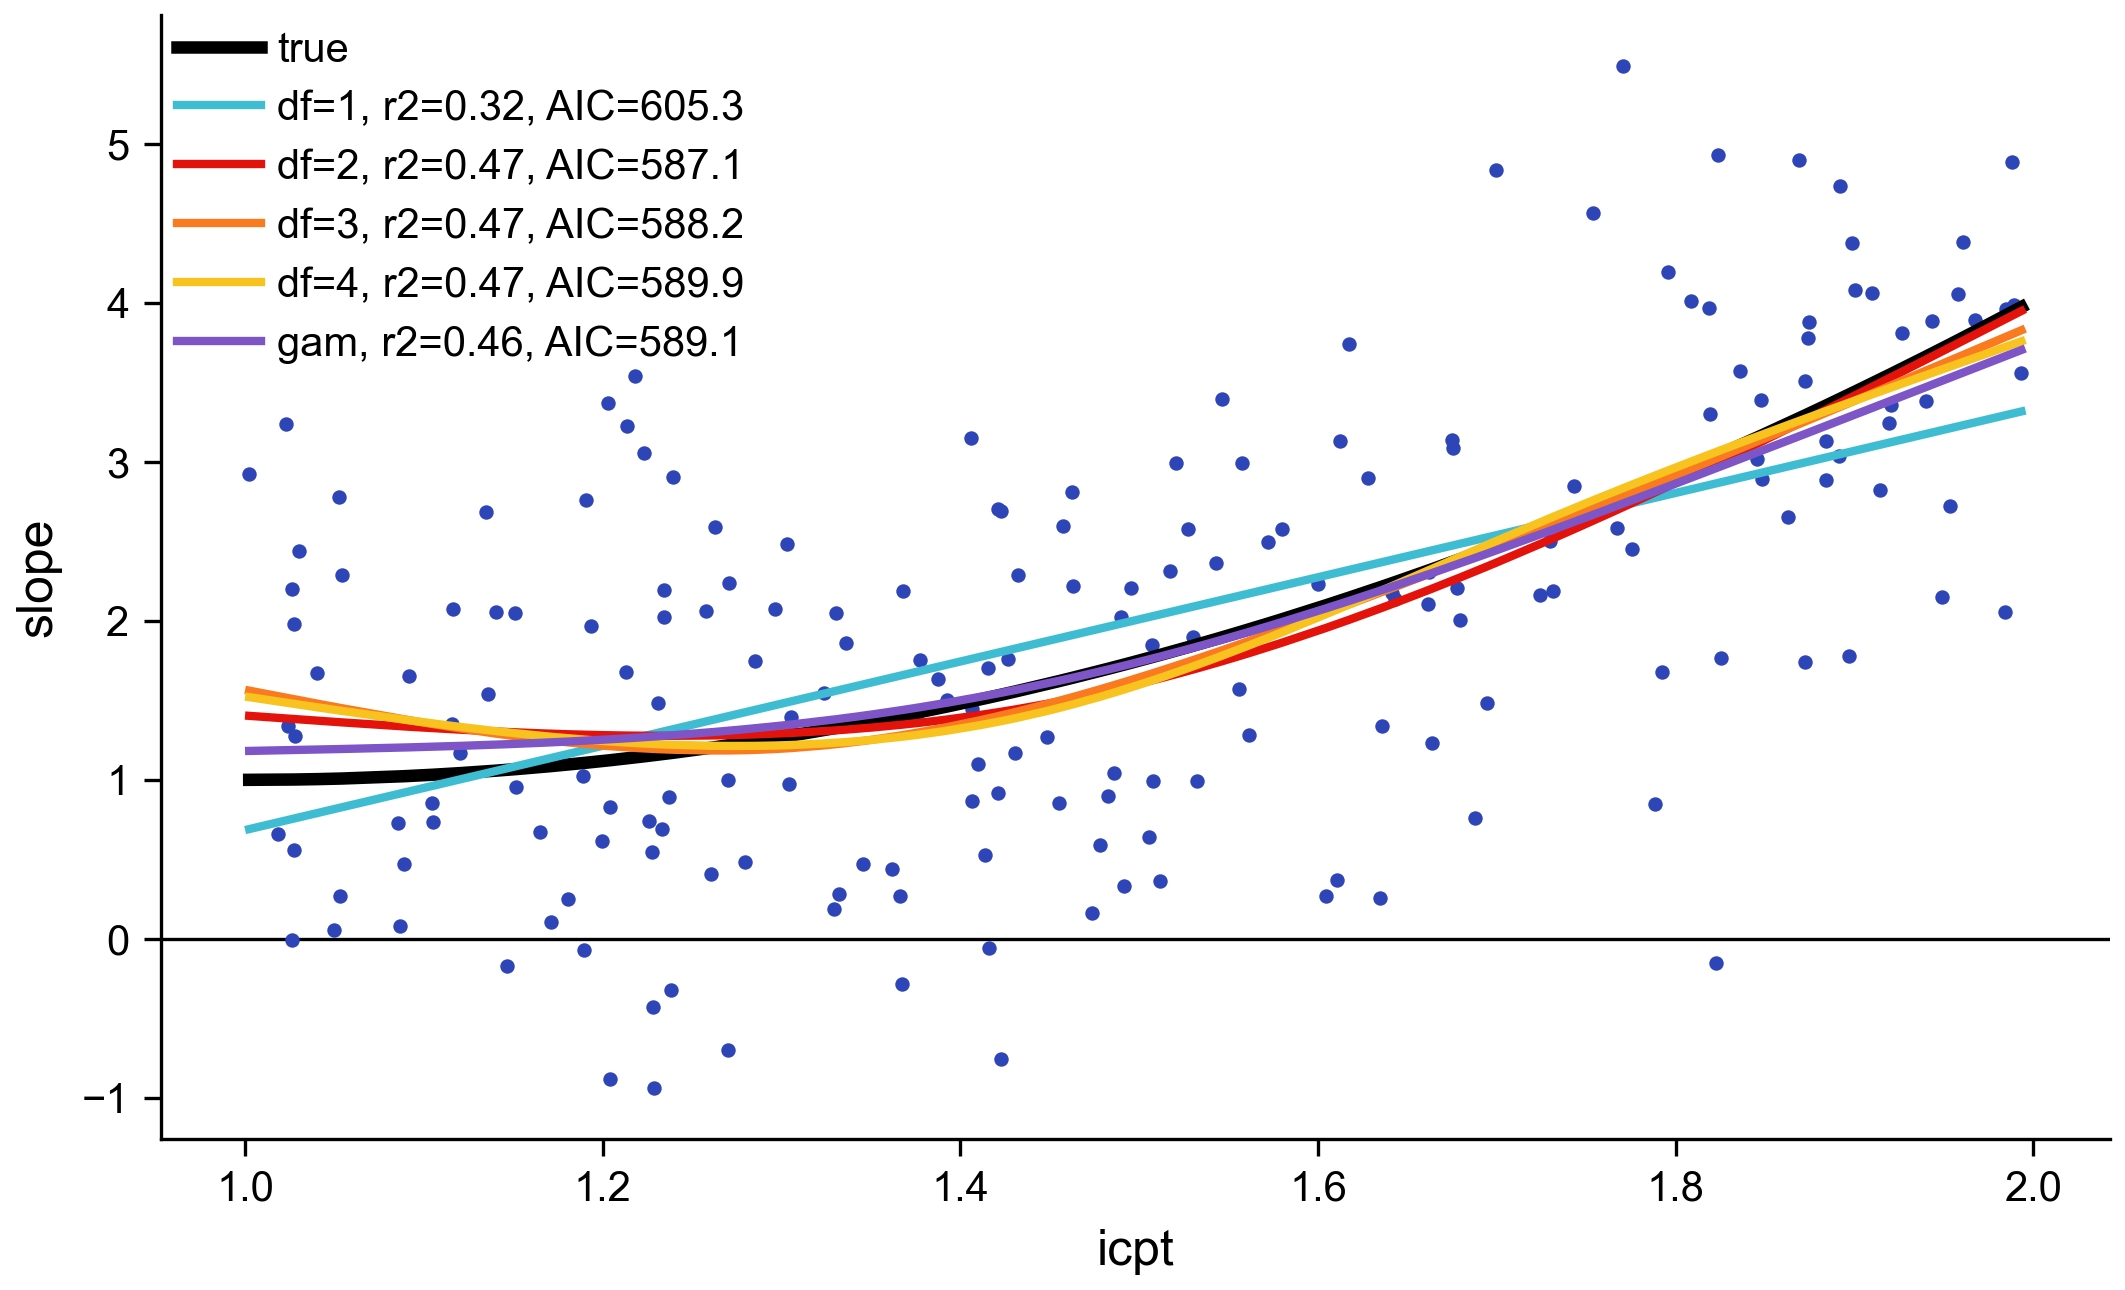

In [824]:
lw = 2
# df = data_ols.query("(key=='frontal') & (n_obs>1)").reset_index(drop=True).copy()

nobs = 200
df = (
    pd.DataFrame(data=1 + (np.random.beta(1, 1, nobs)), columns=["icpt"])
    .sort_values("icpt")
    .reset_index(drop=True)
)
# slope = 3 * np.sin(0.2 * df["icpt"])
slope = 1 + (
    3 * (df["icpt"] - df["icpt"].min()) ** 2 / (df["icpt"].max() - df["icpt"].min())
)
# noise = 10 * np.random.beta(1, 4, nobs)
noise = np.random.normal(0, 1, nobs)
# noise -= noise.mean()
df["slope"] = slope + noise

plt.plot(
    df["icpt"],
    slope,
    color="k",
    lw=lw * 1.5,
    label="true",
)

sns.scatterplot(x="icpt", y="slope", data=df, s=12, linewidth=0, alpha=1)

# Fit a linear regression...
endog = df["slope"]
exog = sm.add_constant(df["icpt"])
fit1 = sm.OLS(endog, exog).fit()
df["pred"] = fit1.fittedvalues
plt.plot(
    "icpt",
    "pred",
    data=df.sort_values("icpt"),
    color=co["c"],
    lw=lw,
    label="df=1, r2={:.2f}, AIC={:.1f}".format(fit1.rsquared_adj, fit1.aic),
)

exog = sm.add_constant(get_cr(df["icpt"], df=2))
fit2 = sm.GLM(endog, exog).fit()
df["pred"] = fit2.fittedvalues
plt.plot(
    "icpt",
    "pred",
    data=df.sort_values("icpt"),
    color=co["r"],
    lw=lw,
    label="df=2, r2={:.2f}, AIC={:.1f}".format(fit2.pseudo_rsquared(), fit2.aic),
)

exog = sm.add_constant(get_cr(df["icpt"], df=3))
fit3 = sm.GLM(endog, exog).fit()
df["pred"] = fit3.fittedvalues
plt.plot(
    "icpt",
    "pred",
    data=df.sort_values("icpt"),
    color=co["o"],
    lw=lw,
    label="df=3, r2={:.2f}, AIC={:.1f}".format(fit3.pseudo_rsquared(), fit3.aic),
)

exog = sm.add_constant(get_cr(df["icpt"], df=4))
fit4 = sm.GLM(endog, exog).fit()
df["pred"] = fit4.fittedvalues
plt.plot(
    "icpt",
    "pred",
    data=df.sort_values("icpt"),
    color=co["y"],
    lw=lw,
    label="df=4, r2={:.2f}, AIC={:.1f}".format(fit4.pseudo_rsquared(), fit4.aic),
)

# Perform random search to find the best penalization factor, alpha_optimal, using 5-fold CV.
bspline_df = 8
alpha_best = find_alpha_cv(df, n_splits=4, n_iter=13)
print(f"alpha_best: {alpha_best}")
modg = GLMGam(
    endog,
    exog=np.ones(endog.shape),
    smoother=BSplines(df["icpt"], df=bspline_df, degree=3, constraints="center"),
    alpha=alpha_best,
)
fitg = modg.fit()
df["pred"] = fitg.fittedvalues
plt.plot(
    "icpt",
    "pred",
    data=df.sort_values("icpt"),
    color=co["v"],
    lw=lw,
    label="gam, r2={:.2f}, AIC={:.1f}".format(fitg.pseudo_rsquared(), fitg.aic),
)

plt.axhline(0, color=co["k"], lw=0.8, zorder=0)

plt.legend()

In [400]:
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  slope   No. Observations:                  187
Model:                            GLM   Df Residuals:                      183
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                        0.013321
Method:                          IRLS   Log-Likelihood:                 140.45
Date:                Sun, 18 Feb 2024   Deviance:                       2.4377
Time:                        00:49:33   Pearson chi2:                     2.44
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1652
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0943      0.008     11.172      0.000       0.078       0.111
icpt0          0.0954      0.027      3.544      0.000       0.043       0.148
icpt1          0.0734      0.028      2.586      0.010       0.018       0.129
icpt2         -0.2334      0.069     -3.372      0.001      -0.369      -0.098
==============================================================================
"""

In [311]:
from statsmodels.gam.generalized_additive_model import GLMGam

In [396]:
fit.aic, fit2.aic, fit3.aic
fit.

(-273.0114482527543, -272.90865724597825, -272.46294676977607)

In [305]:
fit.summary(), fit2.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                  Generalized Linear Model Regression Results                  
 Dep. Variable:                  slope   No. Observations:                  187
 Model:                            GLM   Df Residuals:                      184
 Model Family:                Gaussian   Df Model:                            2
 Link Function:               Identity   Scale:                        0.021705
 Method:                          IRLS   Log-Likelihood:                 96.353
 Date:                Sun, 18 Feb 2024   Deviance:                       3.9068
 Time:                        00:20:54   Pearson chi2:                     3.91
 No. Iterations:                     3   Pseudo R-squ. (CS):             0.1200
 Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ---------------------------------------------------------------------

In [261]:
BSplines(df["slope"], df=5, degree=3, constraints="center")

In [265]:
endog = df["slope"]
exog = sm.add_constant(get_cr(df["icpt"]))
# GLMGam(endog=endog, exog=exog)
fit = sm.GLM(endog, exog).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  slope   No. Observations:                  187
Model:                            GLM   Df Residuals:                      181
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                        0.020803
Method:                          IRLS   Log-Likelihood:                 99.799
Date:                Sun, 18 Feb 2024   Deviance:                       3.7654
Time:                        00:09:51   Pearson chi2:                     3.77
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1559
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0821      0.011      7.787      0.000       0.061       0.103
icpt0          0.1050      0.040      2.603      0.009       0.026       0.184
icpt1          0.0814      0.026      3.176      0.001       0.031       0.132
icpt2          0.0020      0.024      0.082      0.935      -0.045       0.049
icpt3          0.0337      0.036      0.938      0.348      -0.037       0.104
icpt4         -0.2768      0.073     -3.791      0.000      -0.420      -0.134
==============================================================================
"""

In [254]:
df["icpt"].name

'icpt'

In [256]:
get_cr(df["icpt"], 7)

,icpt0,icpt1,icpt2,icpt3,icpt4,icpt5,icpt6
3546,-0.340770,-0.235888,-0.448680,0.045836,-1.190257,1.018116,0.125212
3547,-0.183753,-0.146057,-0.176724,-0.253359,0.090262,0.616790,-0.049608
3548,-0.131353,-0.114120,0.865797,-0.134565,-0.035108,-0.210561,-0.033176
3549,-0.339214,-0.234427,-0.447959,0.051290,-1.199719,1.009484,0.143564
3550,-0.039295,-0.045974,0.013179,-0.271511,1.006514,0.107739,-0.014020
...,...,...,...,...,...,...,...
3728,-0.138980,0.087094,0.777377,-0.227705,-0.005464,-0.198271,-0.030666
3729,-0.034617,-0.040697,0.012290,-0.242086,1.027565,0.075055,-0.012005
3730,-0.146746,0.321888,0.587330,-0.241002,0.002158,-0.186586,-0.028707
3731,-0.227152,-0.357963,-0.339272,-0.409274,-0.086451,-0.580856,-0.091304


In [253]:
def get_cr(x, df=5, constraints="center"):
    xout = patsy.cr(x, df=df, constraints=constraints)
    xout.columns = [f"{x.name}{ii}" for ii in range(xout.shape[1])]
    return xout

In [262]:
patsy.dmatrix("cr(iv,df = 5)", {"iv": df["icpt"]}, return_type="dataframe")

,Intercept,"cr(iv, df=3)[0]","cr(iv, df=3)[1]","cr(iv, df=3)[2]"
3546,1.0,-0.143229,0.647003,0.496227
3547,1.0,-0.158971,0.920006,0.238966
3548,1.0,0.042898,0.974593,-0.017491
3549,1.0,-0.140495,0.630067,0.510428
3550,1.0,-0.135322,0.991644,0.143678
...,...,...,...,...
3728,1.0,0.067264,0.957827,-0.025091
3729,1.0,-0.132759,0.995250,0.137509
3730,1.0,0.090697,0.940493,-0.031190
3731,1.0,0.961021,0.043594,-0.004614


In [ ]:
transformed_x3 = patsy.dmatrix(
    "cr(iv,df = 3)", {"iv": _dat[xcol]}, return_type="dataframe"
)
_dat["fit"] = sm.GLM(_dat["chg_yr_re"], transformed_x3).fit().predict()